**1. Importing Packages**

In [1]:
# ignoring the warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from textwrap import wrap
from wordcloud import WordCloud
from nltk import FreqDist 

# Removing Stopwords 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize

# Lemmatization 
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


**2. Reading Data**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('/content/gdrive/MyDrive/Project_E_commerce.csv',encoding='unicode_escape')
data.head()

Mounted at /content/gdrive


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
data.shape

(541909, 8)

**3. Understanding and Preparing Data**

**3.1. Handling Missing Values**

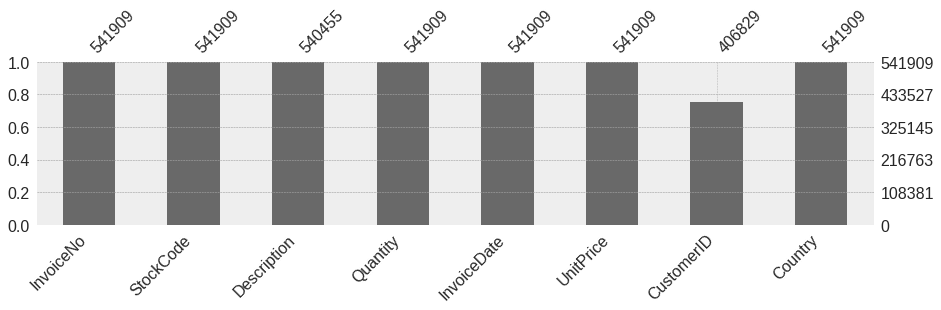

In [4]:
# Visulaising missing value
plt.style.use('bmh')
msno.bar(data,figsize = (15,3))
plt.show()

In [5]:
# Dropping missing value in CustomerID and Description
data = data.dropna(subset =['Description','CustomerID'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


 **3.2. Handling Duplicates**

In [6]:
# checking for duplicates
data.duplicated().sum()

5225

In [7]:
# dropping duplicates 
data = data.drop_duplicates()
data.duplicated().sum()

0

In [8]:
data.shape

(401604, 8)

 **3.3. Detecting and Treating outliers in the data**

In [9]:
# checking outliers in data
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()

Country            0
CustomerID         0
Description        0
InvoiceDate        0
InvoiceNo          0
Quantity       26646
StockCode          0
UnitPrice      35802
dtype: int64

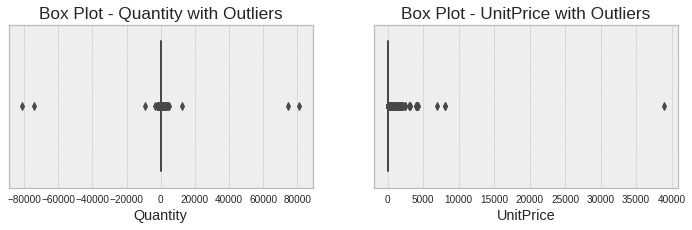

In [10]:
# Visualization of outliers in 'Quantity' & 'UnitPrice' column
plt.style.use('bmh')
plt.figure(figsize=(12,3))
plt.subplot(121)
sns.boxplot(data['Quantity'])
plt.title('Box Plot - Quantity with Outliers')
plt.subplot(122)
sns.boxplot(data['UnitPrice'])
plt.title('Box Plot - UnitPrice with Outliers')
plt.show()

In [11]:
# creating dataframe to view details of extreme negative outliers in 'Quantity' column
df_Quantity_negative = data[data.Quantity <= -60000.0].groupby(['CustomerID','Description'])
df_Quantity_negative.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/2011 9:27,2.08,16446.0,United Kingdom


In [12]:
# creating dataframe to view details of extreme positive outliers in 'Quantity' column
df_Quantity_positive = data[data.Quantity >= 60000.0].groupby(['CustomerID','Description'])
df_Quantity_positive.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom



Observation:

We can infer from the orders with negative quantity > -60,000 and their corresponding 'InvoiceNo' column we see that each one has a 'C' in front of it from which we can infer that order is cancelled. 

We can easily check with Stock Code that the number of orders > 60000 are the same as the number of orders with a 'C' in front of their 'InvoiceNo'. We will drop this Quanity from our dataset as it looks as cancelled or returned order.

In [13]:
# clipping outliers in Quantity & UnitPrice
q3 = data.UnitPrice.quantile(0.75)
q1 = data.UnitPrice.quantile(0.25)
iqr = q3 - q1 
#thresholds
upper = q3 + (1.5 * iqr)
lower = q1 - (1.5 * iqr)
print(upper)
print(lower)

7.5
-2.5


In [14]:
data.Quantity = data.Quantity.clip(-13,27)
data.UnitPrice = data.UnitPrice.clip(-2.5,7.5)

**3.4. Data preprocessing and EDA**

In [15]:
data.Description.value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2058
REGENCY CAKESTAND 3 TIER              1894
JUMBO BAG RED RETROSPOT               1659
PARTY BUNTING                         1409
ASSORTED COLOUR BIRD ORNAMENT         1405
                                      ... 
PINK/WHITE GLASS DEMI CHOKER             1
 I LOVE LONDON MINI RUCKSACK             1
SET 36 COLOURING PENCILS DOILEY          1
SET 12 COLOURING PENCILS DOILEY          1
PEARL AND CHERRY QUARTZ BRACLET          1
Name: Description, Length: 3896, dtype: int64

In [16]:
data[data['Description'].str.contains('Manual')].shape

(460, 8)

In [17]:
data[data['Description'].str.contains('Commis')].shape

(16, 8)

In [18]:
data[data['Description'].str.contains('POSTAGE')].shape

(1212, 8)

In [19]:
data[data['Description'].str.contains('Discount')].shape

(77, 8)

We can infer that 'Description' columnn has categories other than product description such as Discount, Manual, Postage and commission and hence will remove this categories from 'Description' column

In [20]:
remove_category = ['DOTCOM POSTAGE', 'CRUK Commission', 'Manual', 'POSTAGE','Discount']
data = data[~data['Description'].isin(remove_category)]
data.shape

(399839, 8)

In [21]:
# Creating new column 'Sales' 
data['Sales'] = data['Quantity'] * data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


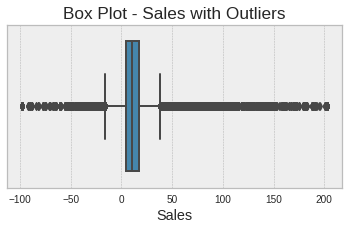

In [22]:
# Visualization of outliers in 'Sales' column
plt.style.use('bmh')
plt.figure(figsize=(6,3))
sns.boxplot(data['Sales'])
plt.title('Box Plot - Sales with Outliers');

In [23]:
# clipping outliers in Sales
data.Sales = data.Sales.clip(-15.925,37.875)

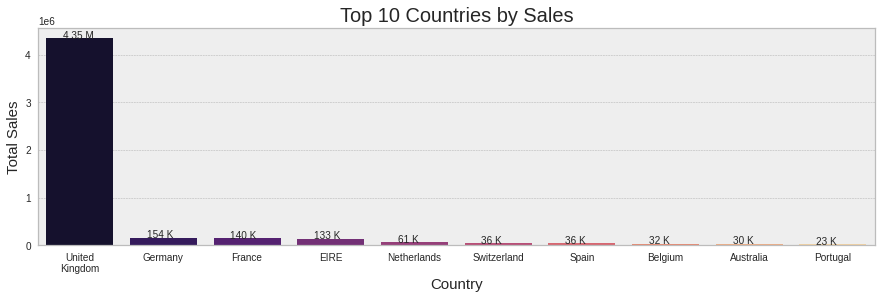

In [24]:
# Visualising Top 10 Countries by Sales
country_order = data.groupby('Country').sum()['Sales'].nlargest(10)
plt.figure(figsize = (15,4))
ax = sns.barplot(x = country_order.index, y = country_order.values, palette = 'magma')
ax.set_xlabel('Country', fontsize = 15)
ax.set_ylabel('Total Sales', fontsize = 15)
ax.set_title('Top 10 Countries by Sales', fontsize = 20)

labels = [ '\n'.join(wrap(l, 12)) for l in country_order.index ]
ax.set_xticklabels(labels, fontsize = 10)

value_labels = []
for x in country_order.values:
    value_labels.append(str(int(x/1000))+' K')
value_labels[0] = '4.35 M'

for p, label in zip(ax.patches, value_labels):
    ax.annotate(label, (p.get_x() + 0.20, p.get_height() + 2), fontsize = 10)

We can infer that total sales E commerce website in United Kingdom is 4.35 Million and while comparing other countries sales seems to be negligable.

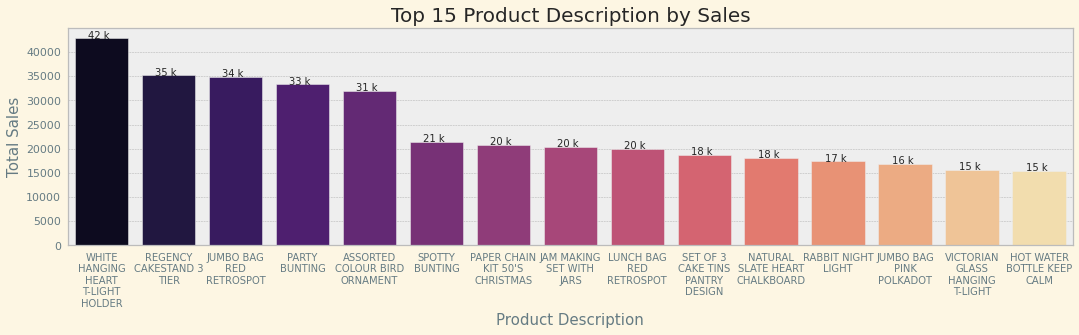

In [67]:
# Visulaising top 15 product Description by Sales
product_order = data.groupby('Description').sum()['Sales'].nlargest(15)

plt.figure(figsize = (18,4))
ax = sns.barplot(x = product_order.index, y = product_order.values, palette = 'magma')
ax.set_xlabel('Product Description', fontsize = 15)
ax.set_ylabel('Total Sales', fontsize = 15)
ax.set_title('Top 15 Product Description by Sales', fontsize = 20)

labels = [ '\n'.join(wrap(l, 12)) for l in product_order.index ]
ax.set_xticklabels(labels, fontsize = 10)

value_labels = []
for x in product_order.values:
    value_labels.append(str(int(x/1000))+' k')

for p, label in zip(ax.patches, value_labels):
    ax.annotate(label, (p.get_x() + 0.20, p.get_height() + 2), fontsize = 10)

In [26]:
# checking for duplicates 
data.duplicated().sum()

21

In [27]:
# dropping duplicates 
data = data.drop_duplicates()
data.duplicated().sum()

0

In [28]:
data.shape

(399818, 9)

**4. Text Data preprocessing**

In [29]:
# Replacing punctuations with space
data['Description_processed'] = data['Description'].str.replace("[^a-zA-Z]"," ") 
# Removing digits 
data['Description_processed'] = data['Description_processed'].str.replace("[0-9]"," ")
# making entire text to lowercase
data['Description_processed'] = [str(description).lower() for description in data['Description_processed']]
# repalcing short words 
data['Description_processed'] = data['Description_processed'].apply(lambda row: ' '.join([word for word in row.split() if len(word)>2]))

# Removing stopwords
stop_words = stopwords.words('english')

# Making custom list of words to be removed 
add_words = ['small','pink','red','green','blue','white','black','large','set','purple','grey','ivory','yellow','mini']
stop_words.extend(add_words)
def remove_stopwords(des):
    description_tokenized = word_tokenize(des)
    rev_new = " ".join([i for i in description_tokenized  if i not in stop_words])
    return rev_new

data['Description_processed'] = [remove_stopwords(r) for r in data['Description_processed']]

# Lemmatization
lemmatizer = WordNetLemmatizer()
# Finds the part of speech tag and convert the detailed POS tag into a shallow information
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# lemmatize sentence using pos tag
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

data['Description_processed']  = data['Description_processed'].apply(lambda x: lemmatize_sentence(x))

In [30]:
# unique values in 'Description_processed'
data['Description_processed'].nunique()

3349

In [31]:
data.duplicated().sum()
# dropping duplicates in 'Descsription_processed'
df = data['Description_processed'].drop_duplicates()
df = pd.DataFrame(df)

**4.1. Visualizing frequent word using wordcloud**

In [ ]:
# Visualizing most frequent words in 'Description' 

plt.figure(1,figsize=(30,5))
plt.subplot(131)    
# Plotting Frequent word using wordcloud

all_words = ' '.join([text for text in df['Description_processed']])
wordcloud = WordCloud(width = 1000, height = 500, background_color ='gold', min_font_size = 10,colormap = 'bone').generate(all_words)
plt.imshow(wordcloud) 
plt.axis("off") 

plt.subplot(132)
# Plotting most frequent words using bar chart
sns.set(style = 'dark')
#Extracts words into list and count frequency
all_words = all_words.split()
words_df = FreqDist(all_words)
# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 30) 
words_df.sort_values('count', inplace = True)
# Plotting 30 frequent words
# plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

**4.2. Text Feature Extraction - Using Tf–idf term weighting**

In [33]:
tfidf = TfidfVectorizer(max_features=8000,ngram_range=(2,2))
vectors = tfidf.fit_transform(df.Description_processed).toarray()
featureNames = tfidf.get_feature_names()
X_tfidf = pd.DataFrame(vectors,columns=featureNames)
print("n_samples: %d, n_features: %d" % X_tfidf.shape)
X_tfidf.head()

n_samples: 3349, n_features: 5363


,abc treasure,abstract circle,acapulco mat,account greet,acrylic edwardian,acrylic faceted,acrylic geometric,acrylic hanging,acrylic jewel,acrylic tape,...,zinc metal,zinc plant,zinc planter,zinc star,zinc sweetheart,zinc top,zinc tree,zinc watering,zinc willie,zinc wire
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 **4.3. Performing dimensionality reduction using LSA (Latent semantic analysis)**

In [34]:
lsa = make_pipeline(TruncatedSVD(n_components=100,random_state=10), Normalizer(copy=False))

X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")
print("n_samples: %d, n_features: %d" % X_lsa.shape)

Explained variance of the SVD step: 13.4%
n_samples: 3349, n_features: 100


**4.4. Finding optimal K value for text data clusters**

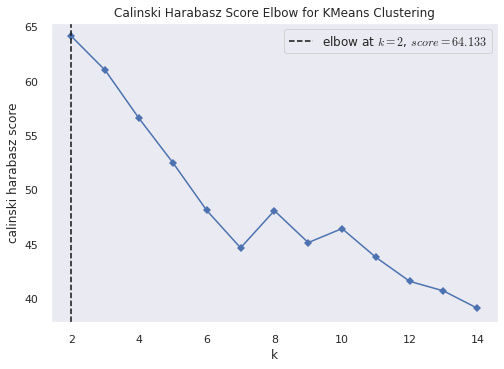

In [35]:
# Finding optimal clusters 'K value' using  Calinski-Harabasz Index
km = KMeans(random_state=10,init='k-means++',n_init=1,max_iter=100)
visualizer = KElbowVisualizer(km, k=(2,15),metric='calinski_harabasz', timings=False)
visualizer.fit(X_lsa)        # Fit the data to the visualizer
visualizer.show() ;  # Finalize and render the figure   

**4.5. Applying KMeans clustering to Text Data**

In [36]:
# Applying K means clusters 
km = KMeans(n_clusters = 2,init='k-means++',random_state=10,n_init=1,max_iter=100)
km.fit(X_lsa)
# knowing centroids
centroids = km.cluster_centers_
# knowing each datapoints which cluter is assigned
cluster = km.labels_
# looking at the value count of points in each of the above-formed clusters:
frame = pd.DataFrame(X_lsa)
frame['Product cluster'] = cluster
frame['Product cluster'].value_counts()
# sns.countplot(frame["Product cluster"]);

0    1822
1    1527
Name: Product cluster, dtype: int64

In [37]:
# Top terms per cluster
original_space_centroids = lsa[0].inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

for i in range(2):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: wall art assort colour wicker heart metal sign wrap christmas paisley park sew kit dolly girl vintage doiley crystal necklace 
Cluster 1: light holder card holder vintage doily cushion cover soft toy vintage paisley knick knack knack tin tile hook jam jar 


**5. Creating Product Categories using text data of 'Description'**

In [38]:
# Reseting index
df = df.reset_index(drop=True)
# Creating DataFrame for cluster labels
df1 = pd.DataFrame(km.labels_)
# joining Dataframe
df2= df.join(df1)
df2.rename(columns={0:'Product_Category'},inplace=True)
# Merging Dataframe
df_new = pd.merge(data, df2, how='left', on='Description_processed')
print(df_new.shape)
df_new.head()

(399818, 11)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Description_processed,Product_Category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,hang heart light holder,1
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,metal lantern,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,cream cupid heart coat hanger,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,knit union flag hot water bottle,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,woolly hottie heart,1


In [39]:
# Filtering only data of United Kingdom as majority of sales is contributed by United Kingdom
df_new = df_new[(df_new.Country == "United Kingdom")]
print(df_new.shape)
df_new.head()

(356135, 11)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Description_processed,Product_Category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,hang heart light holder,1
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,metal lantern,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,cream cupid heart coat hanger,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,knit union flag hot water bottle,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,woolly hottie heart,1


In [40]:
# Knowing counts of unique rows in Product Category
df_new['Product_Category'].value_counts()

0    193753
1    162382
Name: Product_Category, dtype: int64

**5.1. Visualising frequent words in Product Categories**

In [ ]:
# create wordclouds for each Product cluster
plt.subplots(figsize=(20,5))
count=1
for k in range(0,2):
    plt.subplot(1,2,count)
    s=df_new[df_new.Product_Category==k]
    all_words = ' '.join([text for text in s['Description_processed']])
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="black",colormap = 'Paired_r').generate(all_words)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('Product Category: {}'.format(k))
    plt.subplots_adjust(wspace=0.1, hspace=0.0)
    count+=1
plt.show()
  
# Plotting most frequent words in each Product cluster using bar chart
plt.subplots(figsize=(19,5))
sns.set(style = 'dark')
count=1
for k in range(0,2):
  plt.subplot(1,2,count)
  s=df_new[df_new.Product_Category==k]
  all_words = ' '.join([text for text in s['Description_processed']])
  all_words = all_words.split()
  words_df = FreqDist(all_words)
  # Extracting words and frequency from words_df object
  words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
  # Subsets top 20 words by frequency
  words_df = words_df.nlargest(columns="count", n = 20) 
  words_df.sort_values('count', inplace = True)
  ax = plt.barh(words_df['word'], width = words_df['count'])
  plt.title('Product Category: {}'.format(k))
  plt.axis("auto")
  count+=1
plt.show()

**5.2. Visulaising monthly wise sales of each Product category**

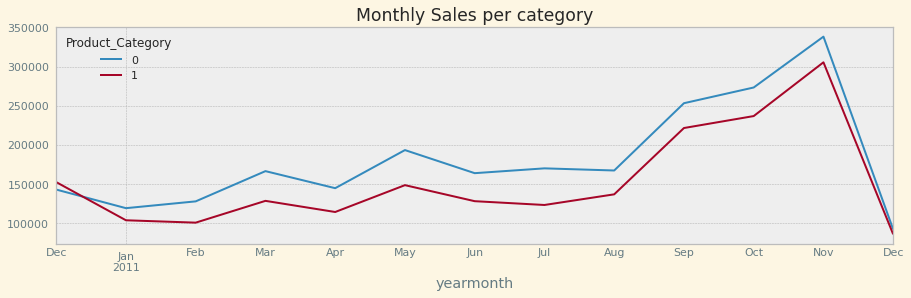

In [66]:
# Visulaising monthly wise sales of each Product category
plt.style.use('bmh')
categories_per_date=df_new.copy()
df_new['InvoiceDate'] = pd.to_datetime(df_new['InvoiceDate'])
categories_per_date['yearmonth']= df_new['InvoiceDate'].dt.to_period('M')
categories_per_date=categories_per_date.pivot_table(index=['yearmonth'], 
                    columns='Product_Category', 
                    values='Sales',
                   # margins=True,  # add margins
                    aggfunc='sum').reset_index()
#categories_per_date.head()
lines=categories_per_date.plot.line(x="yearmonth", y=[0,1],figsize=(15,4),title='Monthly Sales per category')
plt.show()
     

We can infer peak of sales happened in November month ie, for Christmas purchase

**6. Creating Customer Clusters based on Product Categories purchased**

In [43]:
final = df_new.copy()
df3 = df_new.drop(["InvoiceNo","StockCode","Description","InvoiceDate","Description_processed","Quantity","UnitPrice","Country","Sales"],axis=1)
df4 = pd.get_dummies(df3,columns=["Product_Category"])
print(df4.shape)
df4.head()

(356135, 3)


,CustomerID,Product_Category_0,Product_Category_1
0,17850.0,0,1
1,17850.0,0,1
2,17850.0,0,1
3,17850.0,0,1
4,17850.0,0,1


In [44]:
df5 = df4.groupby('CustomerID')['Product_Category_0','Product_Category_1'].sum()
df5.reset_index(inplace=True, level = ['CustomerID'])
df5.head()

,CustomerID,Product_Category_0,Product_Category_1
0,12346.0,2.0,0.0
1,12747.0,58.0,45.0
2,12748.0,2508.0,1930.0
3,12749.0,125.0,106.0
4,12820.0,30.0,29.0


In [45]:
dataset = df5.drop(["CustomerID"],axis=1) 
dataset

,Product_Category_0,Product_Category_1
0,2.0,0.0
1,58.0,45.0
2,2508.0,1930.0
3,125.0,106.0
4,30.0,29.0
...,...,...
3938,4.0,6.0
3939,7.0,0.0
3940,9.0,4.0
3941,374.0,345.0


In [46]:
# Checking outliers in dataset
Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)
IQR = Q3 - Q1
((dataset < (Q1 - 1.5 * IQR)) | (dataset > (Q3 + 1.5 * IQR))).sum()

Product_Category_0    345
Product_Category_1    350
dtype: int64

In [47]:
# Clipping outliers in dataset
dataset['Product_Category_0']= dataset['Product_Category_0'].clip(-58.5,121.5)
dataset['Product_Category_1'] = dataset['Product_Category_1'].clip(-50.0,102.0)

**6.1. Finding optimal K value for cluster**

In [48]:
# Scaling the data
scaler = StandardScaler()
X_std = scaler.fit_transform(dataset)
X_std

array([[-0.93970469, -0.99015496],
       [ 0.5614678 ,  0.44019248],
       [ 2.26369018,  2.2519659 ],
       ...,
       [-0.75205813, -0.86301297],
       [ 2.26369018,  2.2519659 ],
       [ 0.02533477,  0.026981  ]])

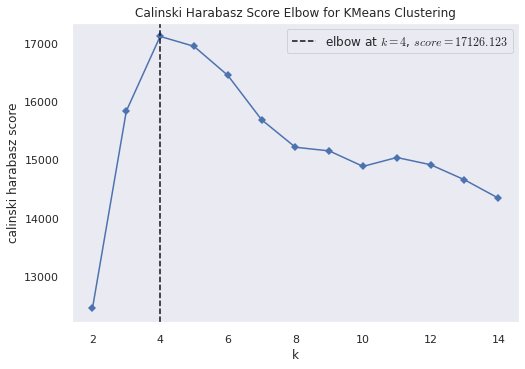

In [50]:
# Finding optimal K value using  Calinski-Harabasz Index
km = KMeans(init='k-means++',random_state=10,n_init=1,max_iter=100)
visualizer = KElbowVisualizer(km, k=(2,15),metric='calinski_harabasz', timings=False)
visualizer.fit(X_std)        
visualizer.show() ;

**6.2. Fitting into model - KMeans clustering** 

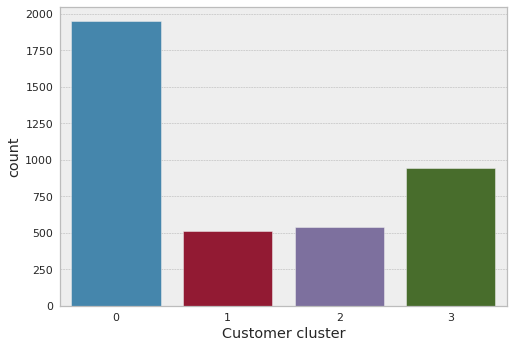

In [74]:
# Fitting K means Algorithm with 4 clusters
km = KMeans(n_clusters = 4,init='k-means++',random_state=10,n_init=1,max_iter=100)
label = km.fit_predict(X_std)
centroids = km.cluster_centers_
cluster = km.labels_

# visualising at the value count of points in each of the above-formed clusters:
frame = pd.DataFrame(X_std)
frame['Customer cluster'] = cluster
frame['Customer cluster'].value_counts()
plt.style.use('bmh')
sns.countplot(frame["Customer cluster"]);

**6.3. Vizualization of Customers clusters**

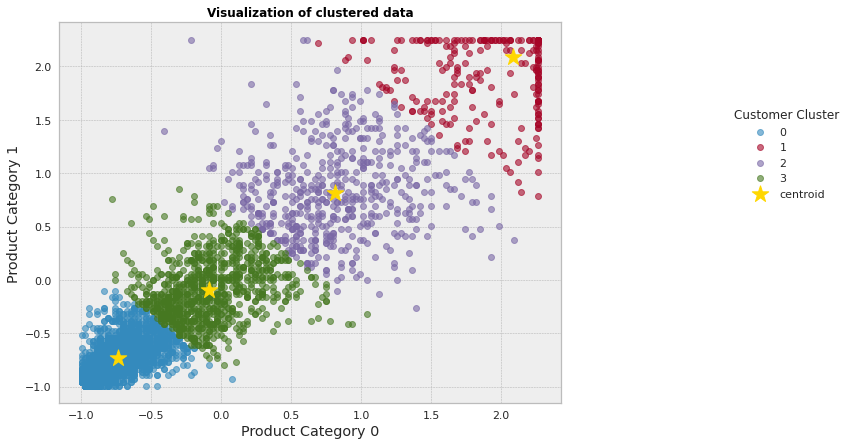

In [84]:
labels = np.unique(label)
plt.style.use('bmh')
plt.figure(figsize=(15, 7)) 
ax = plt.subplot(111)
sns.set_theme(style="whitegrid")
for i in labels:
    plt.scatter(X_std[label == i,0] , X_std[label == i,1] , label = i,alpha=0.6)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 300, marker='*',c='gold', label='centroid')
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(title='Customer Cluster',loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.xlabel('Product Category 0')
plt.ylabel('Product Category 1')
plt.title('Visualization of clustered data',color='black',fontweight='bold')
plt.show()

**6.4. Analysing Product category wise sales in each Customer cluster**

In [77]:
# Reseting index
# df = df.reset_index(drop=True)
# Creating DataFrame for cluster labels
f1 = pd.DataFrame(cluster)
# joining Dataframe
f2= df5.join(f1)
f2.rename(columns={0:'Customer_Category'},inplace=True)
# Merging Dataframe
df_news = pd.merge(df_new, f2, how='left', on='CustomerID')
print(df_news.shape)
df_news.head()

(356135, 14)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Description_processed,Product_Category,Product_Category_0,Product_Category_1,Customer_Category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,hang heart light holder,1,90.0,219.0,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,metal lantern,1,90.0,219.0,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,cream cupid heart coat hanger,1,90.0,219.0,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,knit union flag hot water bottle,1,90.0,219.0,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,woolly hottie heart,1,90.0,219.0,1


In [78]:
# Creating dataframe to understand product category wise sales in each customer cluster
df_product_sales = pd.pivot_table(df_news,values='Sales',index=['Product_Category'],columns=['Customer_Category'],aggfunc='sum')
df_product_sales

Customer_Category,0,1,2,3
Product_Category,,,,
0,290507.457,1172067.430,466373.431,426668.541
1,243319.845,983733.185,404804.760,357966.815


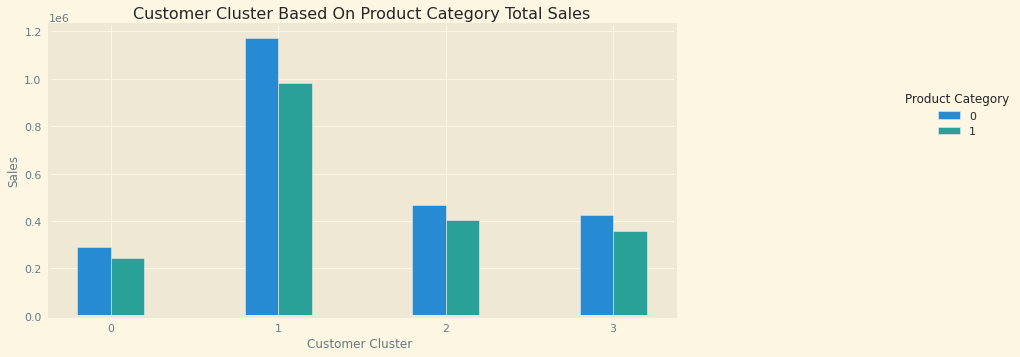

In [86]:
# Visualizing product category wise sales in each customer cluster
plt.style.use('Solarize_Light2')
x = np.arange(len(df_product_sales.columns))
width = 0.2

fig,ax = plt.subplots(figsize=(10,5))
for i in range(len(df_product_sales)):
    ax.bar(x+(i*width),df_product_sales.loc[df_product_sales.index[i]],width=width, label=df_product_sales.index[i])

ax.set_xticks(x+((len(df_product_sales)/2-0.5)*width))
ax.set_xticklabels(df_product_sales.columns)

plt.title('Customer Cluster Based On Product Category Total Sales')
ax.set_xlabel('Customer Cluster ')
ax.set_ylabel('Sales')

plt.legend(title='Product Category',loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.show()

Out of total 4.35 million Sales in United Kingdom.
*   The customers in cluster 1 are contributing 2.15 million Sales 
*   The customers in cluster 2 are contributing 0.87 million Sales
*   The customers in cluster 3 are contributing 0.78 million Sales.
*   The customers in cluster 0 are least contributing 0.53 million Sales 